<a href="https://colab.research.google.com/github/ThumbRocket/AI_Expert_Lecture_Files/blob/main/3Week/3_1_DCGAN_unconditional.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Convolutional Generative Adversarial Network

## Overview
이번 실습에서는 DCGAN을 현하고, MNIST dataset을 이용하여 학습해보록 하겠습니다.

2016년에 제안된 DCGAN(Deep Convolution GAN)은 가장 기본적인 GAN 구조 중 하나입니다.

- 이 실습자료는 [GAN-Tutorial](https://github.com/Yangyangii/GAN-Tutorial)을 기반으로 작성되었습니다.

### Setup

우선, DCGAN 구현을 위해 필요한 패키지들을 설치하고 import하도록 하겠습니다.

In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms
from torchvision.utils import save_image

import numpy as np
import datetime
import os, sys

from matplotlib.pyplot import imshow, imsave

DEVICE = torch.device('cuda')

### Load and prepare the dataset

이번 실습에서 사용할 MNIST dataset을 다운로드하고, 로드하겠습니다.

In [2]:
batch_size = 64

transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(mean=[0.5],
                                std=[0.5])]
)

mnist = datasets.MNIST(root='./data/', train=True, transform=transform, download=True)
data_loader = DataLoader(dataset=mnist, batch_size=batch_size, shuffle=True, drop_last=True)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 17480714.25it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 479308.72it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 4415592.85it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 3830792.03it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [6]:
import matplotlib.pyplot as plt

img, la = mnist[0].squeeze()

plt.imshow(img, cmap='gray')
plt.title(f'Label: {la}')
plt.show()

AttributeError: 'tuple' object has no attribute 'squeeze'

## DCGAN 구현

지금부터 DCGAN 모델을 구현하도록 하겠습니다.

### 1. Generator

Convolutional Auto Encoder의 Decoder와 마찬가지로 transposed convolution을 활용하여, latent $z$로부터 MNIST dataset 이미지를 생성하는 Generator 모델을 만들어보겠습니다.

실제 DCGAN의 Generator는 64x64 이미지를 생성하지만, 이번 실습에서는 MNIST dataset의 사이즈에 맞추어 100차원 latent vector $z$로부터 28x28 이미지를 생성해보도록 하겠습니다.

모델의 구조는 다음과 같습니다.  

1. **Input**: latent $z$, [batch, 100]  

2. **FC**: [batch, 100] → [batch, 512x4x4=8192]
3. **ReLU**
4. **Reshape**: [batch, 512x4x4=8192] → [batch, 512, 4, 4]
5. **ConvTranspose2d**: [batch, 512, 4, 4] → [batch, 256, 7, 7], kernel_size=3, stride=2 padding=1, bias=False
6. **BatchNorm2d**: channel 256
7. **ReLU**
8. **ConvTranspose2d**: [batch, 256, 7, 7] → [batch, 128, 14, 14], kernel_size=4, stride=2, padding=1, bias=False
9. **BatchNorm2d** : channel 128
10. **ReLU**
11. **ConvTranspose2d**: [batch, 128, 14, 14] → [batch, 1, 28, 28], kernel_size=4, stride=2, padding=1, bias=False
12. **Tanh**


Q. 왜 마지막 layer는 Tanh를 사용할까?


In [8]:
class Generator(nn.Module):
    """
        Convolutional Generator for MNIST
    """
    def __init__(self, input_size=100):
        super(Generator, self).__init__()
        ################ ToDo ##################
        self.fc = nn.Sequential(
            # input : input size, output : 4x4x512
            nn.Linear(input_size, 512 * 4 * 4), # batch,100 -> batch,512*4*4
            nn.ReLU()
        )
        self.conv = nn.Sequential(
            # input: 4x4, output: 7x7
            nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            # input: 7x7, output: 14x14
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            # input: 14x14, output: 28x28
            nn.ConvTranspose2d(128, 1, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh()
        )
        #########################################

    def forward(self, z):
        x = z.view(z.size(0), -1)
        x = self.fc(x)
        x = x.view(x.size(0), 512, 4, 4)
        x = self.conv(x)
        return x

In [9]:
G = Generator().to(DEVICE)

아직 학습이 되지 않은 Generator를 이용하여 random sampling된 latent vector로부터 이미지를 생성해보겠습니다.

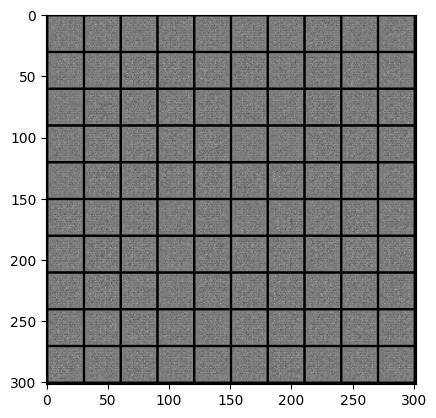

In [10]:
from torchvision.utils import make_grid

G.eval()

n_samples = 100

with torch.no_grad():
  z = torch.randn(n_samples, 100).to(DEVICE)
  x_hat = G(z)

img = make_grid(x_hat, nrow=10, normalize=True, value_range=(-1., 1.)).permute(1, 2, 0).cpu().data.numpy()
imshow(img, cmap='gray')

### 2, Discriminator

Generator가 생성한 이미지의, real/fake 여부를 구분하는 Discriminator를 구현해보도록 하겠습니다.

모델의 구조는 다음과 같습니다.  

1. **Input**: image $x$, [batch, 28, 28, 1]  
2. **Conv2d**: [batch, 1, 28, 28] → [batch, 512, 14, 14], kernel_size=3, stride=2, padding=1, bias=False
3. **BatchNorm2d**
4. **LeakyReLU**  
5. **Conv2d**: [batch, 512, 14, 14] → [batch, 256, 7, 7], kernel_size=5
6. **BatchNorm2d**
7. **LeakyReLU**
8. **Conv2d**: [batch, 256, 7, 7] → [batch, 128, 4, 4],
9. **BatchNorm2d**
10. **LeakyReLU**
11. **AvgPool2d**
12. **reshape**: [batch, 128, 4, 4] → [batch, 128x4x4=2048],
13. **Linear**: [batch, 128x4x4=2048] → [batch, 1]
14. **Sigmoid**
  
Q. 왜 마지막 layer는 sigmoid 일까?

In [30]:
class Discriminator(nn.Module):
    """
        Convolutional Discriminator for MNIST
    """
    def __init__(self, in_channel=1, num_classes=1):
        super(Discriminator, self).__init__()
        ################ ToDo ##################

        self.conv = nn.Sequential(
            # input: 28x28, output: 14x14
            nn.Conv2d(in_channel, 512, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2), # arg : hyperparameter -> 기울기
            # input: 14x14, output: 7x7
            nn.Conv2d(512, 256, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            # input: 7x7, output: 4x4
            nn.Conv2d(256, 128, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.AvgPool2d(4),
            # input: 4x4, output: 1
        )
        self.fc = nn.Sequential(
            # input : 128, output : 1
            nn.Linear(128, 1),
            nn.Sigmoid()
        )
        ##########################################

    def forward(self, x):
        y_ = self.conv(x)
        y_ = y_.view(y_.size(0), -1)
        y_ = self.fc(y_)
        return y_

In [31]:
D = Discriminator().to(DEVICE)

Discriminator를 이용하여 앞에서 생성한 이미지에 대한 real/fake 여부를 판정해보겠습니다.

Discriminator는 real image일 확률을 리턴합니다.

In [32]:
with torch.no_grad():
  decision = D(x_hat)
print (decision[:10].squeeze())

tensor([0.5462, 0.5446, 0.5402, 0.5777, 0.5609, 0.5634, 0.5306, 0.5587, 0.5664,
        0.5423], device='cuda:0')


## Loss와 Optimizer 정의

모델 학습을 위해 loss와 optimizer를 선언해주도록 하겠습니다.

### Discriminator loss

아래 코드는 Discriminator를 위한 loss 구현 코드입니다.  
Discriminator의 학습 목표는, real image에 대해서는 1(or 높은 확률값)을 반환하고, fake image에 대해서는 0(or 낮은 확률값)을 반환하는 것입니다.

In [22]:
def discriminator_loss(real_output, fake_output):
    ################ ToDo ##################
    D_real_labels = torch.ones_like(real_output)
    D_fake_labels = torch.zeros_like(fake_output)

    real_loss = nn.BCELoss()(real_output, D_real_labels) # 1이 되도록
    fake_loss = nn.BCELoss()(fake_output, D_fake_labels) # 0이 되도록
    total_loss = real_loss + fake_loss
    ########################################
    return total_loss

### Generator loss
아래 코드는 Generator를 위한 loss 구현 코드입니다.  
Generator의 학습 목표는, discriminator를 속이는 것이며, 이는 fake output에 대해 1(or 높은 확률값)을 반환하도록 하는 것입니다.

In [33]:
def generator_loss(fake_output):
    ################ ToDo ##################
    G_fake_labels = torch.ones_like(fake_output)
    loss = nn.BCELoss()(fake_output, G_fake_labels) # 0이 되도록
    ########################################
    return loss

아래 코드는 각각의 model에 대한 optimizer를 선언해주는 코드입니다.

In [34]:
D_opt = torch.optim.Adam(D.parameters(), lr=0.001, betas=(0.5, 0.999))
G_opt = torch.optim.Adam(G.parameters(), lr=0.001, betas=(0.5, 0.999))

## Define the training loop

In [35]:
EPOCHS = 10
noise_dim = 100
num_examples_to_generate = 16
global_step = 0
n_critic = 1

아래 코드는 DCGAN 학습을 위한 train_step 코드입니다.  
1. 각 train_step마다 Generator는 **BATCH_SIZE**개 만큼의 이미지를 생성합니다.  
2. Discriminator는 Generator가 만든 **BATCH_SIZE**개의 이미지와, training set에서 가져온 **BATCH_SIZE**개의 이미지, 총 **2xBATCH_SIZE**개의 이미지에 대해 real/fake 판별을 진행합니다.
3. 이후 Generator, Discriminator에 대한 loss를 계산하고, Gradient를 계산한 뒤
4. Model의 Parameter를 업데이트해주게 됩니다.

In [36]:
G.train()
D.train()

G_train_loss_list = []
D_train_loss_list = []


for epoch in range(EPOCHS):
    for idx, (x, y) in enumerate(data_loader):
        # Training Discriminator
        x = x.to(DEVICE)
        D_real_preds = D(x)

        z = torch.randn(batch_size, noise_dim).to(DEVICE)
        D_fake_preds = D(G(z))

        D_loss = discriminator_loss(D_real_preds, D_fake_preds)

        D.zero_grad()
        D_loss.backward()
        D_opt.step()

        if global_step % n_critic == 0:
            # Training Generator
            z = torch.randn(batch_size, noise_dim).to(DEVICE)
            D_fake_preds = D(G(z))
            G_loss = generator_loss(D_fake_preds)

            D.zero_grad()
            G.zero_grad()
            G_loss.backward()
            G_opt.step()

        if global_step % 500 == 0:
            print('Epoch: {}/{}, Step: {}, D Loss: {}, G Loss: {}'.format(epoch, EPOCHS, global_step, D_loss.item(), G_loss.item()))

        if global_step % 50 == 0:
            G_train_loss_list.append(G_loss.data.item())
            D_train_loss_list.append(D_loss.data.item())

        global_step += 1

Epoch: 0/10, Step: 0, D Loss: 1.4132144451141357, G Loss: 0.6038026809692383
Epoch: 0/10, Step: 500, D Loss: 0.995703399181366, G Loss: 1.1004338264465332
Epoch: 1/10, Step: 1000, D Loss: 0.963093638420105, G Loss: 1.5105886459350586
Epoch: 1/10, Step: 1500, D Loss: 1.0160329341888428, G Loss: 0.5549740195274353
Epoch: 2/10, Step: 2000, D Loss: 0.8729901909828186, G Loss: 1.8923790454864502
Epoch: 2/10, Step: 2500, D Loss: 0.8148801922798157, G Loss: 1.3012535572052002
Epoch: 3/10, Step: 3000, D Loss: 0.6667906045913696, G Loss: 2.077573537826538
Epoch: 3/10, Step: 3500, D Loss: 0.8377798199653625, G Loss: 0.8713173866271973
Epoch: 4/10, Step: 4000, D Loss: 0.4014595150947571, G Loss: 1.3956679105758667
Epoch: 4/10, Step: 4500, D Loss: 0.8043890595436096, G Loss: 1.6612292528152466
Epoch: 5/10, Step: 5000, D Loss: 0.9357366561889648, G Loss: 2.463015556335449
Epoch: 5/10, Step: 5500, D Loss: 0.7097217440605164, G Loss: 1.8165383338928223
Epoch: 6/10, Step: 6000, D Loss: 0.8580344915390

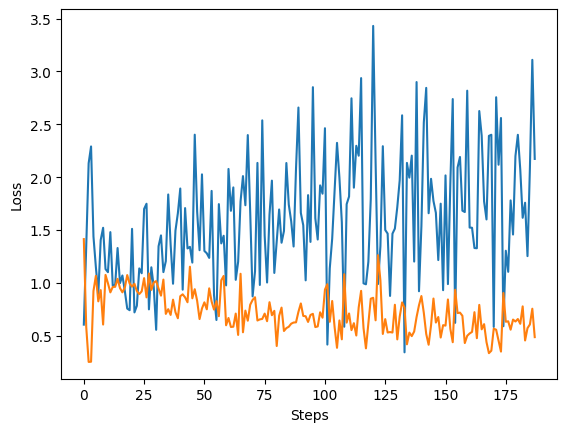

In [37]:
import matplotlib.pyplot as plt
plt.ion()

fig = plt.figure()
plt.plot(G_train_loss_list)
plt.plot(D_train_loss_list)
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.show()

### Generate and save images
아래 코드는 모델로부터 이미지를 생성하고 이를 확인하는 코드입니다.

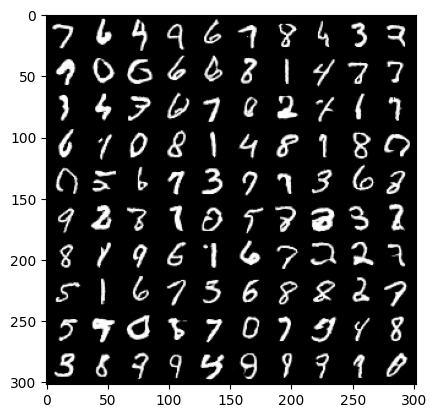

In [38]:
from torchvision.utils import make_grid

G.eval()

n_samples = 100

with torch.no_grad():
  z = torch.randn(n_samples, 100).to(DEVICE)
  x_hat = G(z)

img = make_grid(x_hat, nrow=10, normalize=True, value_range=(-1., 1.)).permute(1, 2, 0).cpu().data.numpy()

imshow(img, cmap='gray')